In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import seaborn as sns


In [4]:
#get jobzone df
jz = pd.read_excel('datasets/job_zone.xlsx')
jz.columns = jz.columns.str.lower().str.replace(" ","_")
jz = jz.drop(labels=['date', 'domain_source','o*net-soc_code'], axis=1)   
jz = jz.rename(columns={'job_zone':'zone'})

In [5]:
# Set folder path
folder_name = "results/jm"

# Get all JSON files
json_files = [f for f in os.listdir(folder_name) if f.endswith('.json')]

#get the model name. stop at the second underscore
model_name = [json_files[:-5] for json_files in json_files]


In [6]:
model_name

['deepseek_no_prompt',
 'deepseek_prompt_1',
 'llama_no_prompt',
 'llama_prompt_1',
 'mistral_no_prompt',
 'mistral_prompt_1']

In [7]:
def mean_perfect_array(df):
    #get the mean difference in df, by iteration, into a np array
    return df.groupby("iteration")["perfect_match"].mean().to_numpy()

def mean_related_array(df):
    #get the mean difference in df, by iteration, into a np array
    return df.groupby("iteration")["related"].mean().to_numpy()

In [8]:
perfect_array_list = []
related_array_list = []

# Loop through each JSON file and load it into the DataFrame
for json_file in json_files:
    df = pd.read_json(f"{folder_name}/{json_file}").dropna()
    #drop the iteration column'
    df = df.drop(labels=['rating'], axis=1)
    #normalize related score to 0-1
    df['related'] = df['related']/10
    #get the mean difference in df, by iteration, into a np array
    perfect_array = mean_perfect_array(df)
    related_array = mean_related_array(df)
    perfect_array_list.append(perfect_array)
    related_array_list.append(related_array)

print(perfect_array_list)
print(related_array_list)

[array([0.13043478, 0.08695652, 0.15217391, 0.08695652, 0.06521739,
       0.13043478, 0.19565217, 0.13043478, 0.23913043, 0.13043478]), array([0.26086957, 0.2173913 , 0.23913043, 0.19565217, 0.2173913 ,
       0.26086957, 0.17391304, 0.2173913 , 0.17391304, 0.30434783]), array([0.17391304, 0.19565217, 0.2173913 , 0.15217391, 0.2173913 ,
       0.15217391, 0.2173913 , 0.13043478, 0.23913043, 0.2173913 ]), array([0.23913043, 0.19565217, 0.26086957, 0.2173913 , 0.2173913 ,
       0.2826087 , 0.2173913 , 0.26086957, 0.26086957, 0.2173913 ]), array([0.06521739, 0.06521739, 0.13043478, 0.10869565, 0.17391304,
       0.13043478, 0.10869565, 0.13043478, 0.10869565, 0.10869565]), array([0.13043478, 0.13043478, 0.19565217, 0.13043478, 0.15217391,
       0.15217391, 0.17391304, 0.13043478, 0.10869565, 0.10869565])]
[array([0.05434783, 0.0673913 , 0.05652174, 0.04782609, 0.03478261,
       0.05434783, 0.06304348, 0.05652174, 0.1       , 0.05217391]), array([0.15652174, 0.13695652, 0.13478261, 0.1

plot general matching result, only consider performance by run

Descriptive Statistics:
deepseek_no_prompt: Mean = 0.0587, Variance = 0.0003
deepseek_prompt_1: Mean = 0.1326, Variance = 0.0004
llama_no_prompt: Mean = 0.1200, Variance = 0.0002
llama_prompt_1: Mean = 0.1722, Variance = 0.0004
mistral_no_prompt: Mean = 0.0689, Variance = 0.0002
mistral_prompt_1: Mean = 0.0950, Variance = 0.0001

Levene's Test for Equal Variances: p-value = 0.4022

ANOVA Results:
F-statistic: 64.4955
p-value: 0.0000
Result: Reject the null hypothesis. There is a significant difference between the groups.


C:\Users\godfr\AppData\Local\Temp\ipykernel_21328\461719860.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels)


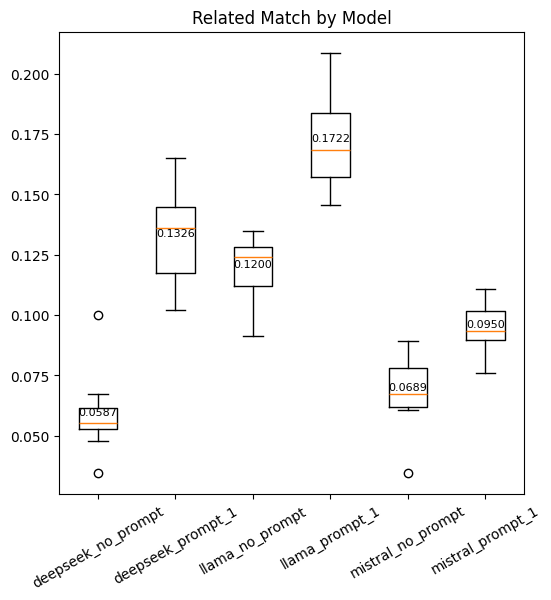

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

groups = related_array_list
labels = model_name

# Descriptive stats
print("Descriptive Statistics:")
for label, group in zip(labels, groups):
    print(f"{label}: Mean = {np.mean(group):.4f}, Variance = {np.var(group):.4f}")

# Check for equal variances (Levene's test)
levene_stat, levene_p = stats.levene(*groups)
print(f"\nLevene's Test for Equal Variances: p-value = {levene_p:.4f}")
if levene_p < 0.05:
    print("Warning: Variances may not be equal (p < 0.05). Consider a robust alternative if significant.")

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(*groups)
print(f"\nANOVA Results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Result: Reject the null hypothesis. There is a significant difference between the groups.")
else:
    print("Result: Fail to reject the null hypothesis. No significant difference between the groups.")

# Boxplot for visualization
plt.figure(figsize=(6, 6))
plt.boxplot(groups, labels=labels)
# plt.ylabel('Scores')
plt.title('Related Match by Model')
# plt.grid(True)
for i, group in enumerate(groups):
    max = np.max(group)
    mean = np.mean(group)
    plt.annotate(f'{mean:.4f}', xy=(i + 1, mean), xytext=(i + 1, mean),
                 fontsize=8, ha='center')
# plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_21328\1969984688.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels)


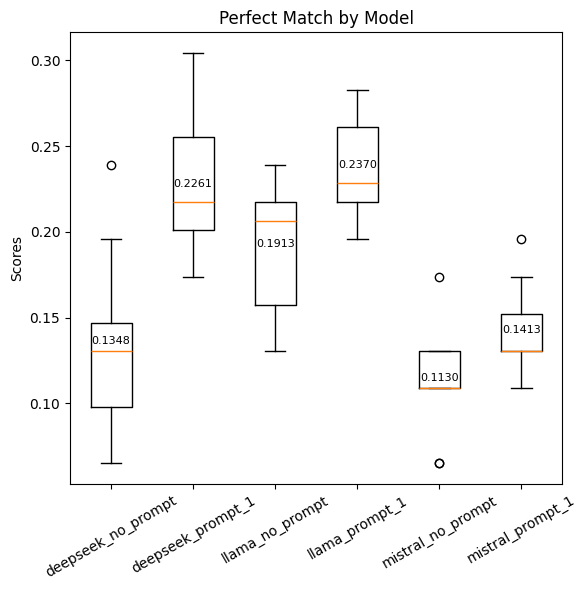

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

groups = perfect_array_list
labels = model_name

# Boxplot for visualization
plt.figure(figsize=(6, 6))
plt.boxplot(groups, labels=labels)
plt.ylabel('Scores')
plt.title('Perfect Match by Model')
# plt.grid(False)
plt.xticks(rotation=30)
#annotate the mean of each group
for i, group in enumerate(groups):
    mean = np.mean(group)
    plt.annotate(f'{mean:.4f}', xy=(i + 1, mean), xytext=(i + 1, mean),
                 fontsize=8, ha='center')
plt.tight_layout()
plt.show()

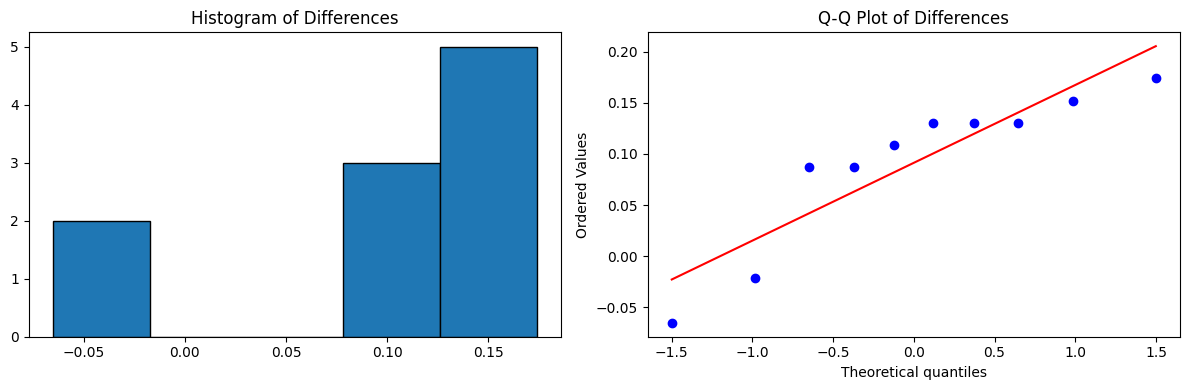

Shapiro-Wilk Statistic: 0.8356, P-value: 0.0391
Anderson-Darling Statistic: 0.7774
Critical Value at 15.0%: 0.5010, Not Normal
Critical Value at 10.0%: 0.5700, Not Normal
Critical Value at 5.0%: 0.6840, Not Normal
Critical Value at 2.5%: 0.7980, Normal
Critical Value at 1.0%: 0.9500, Normal


In [199]:
#check if the the data is normally distributed
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
i = 0

df1 = pd.read_json(os.path.join(folder_name, json_files[i]), lines=False).dropna()

df2 = pd.read_json(os.path.join(folder_name, json_files[i+1]), lines=False).dropna()

# Example data

# control_means = df1.groupby("iteration")["related"].mean().to_numpy()
# test_means = df2.groupby("iteration")["related"].mean().to_numpy()

control_means = df1.groupby("iteration")["perfect_match"].mean().to_numpy()
test_means = df2.groupby("iteration")["perfect_match"].mean().to_numpy()
differences = test_means - control_means

# Histogram
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(differences, bins=5, edgecolor='black')
plt.title("Histogram of Differences")

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(differences, dist="norm", plot=plt)
plt.title("Q-Q Plot of Differences")
plt.tight_layout()
plt.show()

# Shapiro-Wilk Test
stat, p_value = stats.shapiro(differences)
print(f"Shapiro-Wilk Statistic: {stat:.4f}, P-value: {p_value:.4f}")

# Anderson-Darling Test
result = stats.anderson(differences)
print(f"Anderson-Darling Statistic: {result.statistic:.4f}")
for crit_val, sig_level in zip(result.critical_values, result.significance_level):
    print(f"Critical Value at {sig_level}%: {crit_val:.4f}, {'Normal' if result.statistic < crit_val else 'Not Normal'}")

In [122]:
# data is not normally distributed, use the Wilcoxon signed-rank test
# find the p-value for the Wilcoxon signed-rank test for the two models, general performance
from scipy.stats import wilcoxon
i = 4

df1 = pd.read_json(os.path.join(folder_name, json_files[i]), lines=False).dropna()
df2 = pd.read_json(os.path.join(folder_name, json_files[i+1]), lines=False).dropna()


# Example mean scores for 10 runs
control_means = df1.groupby("iteration")["perfect_match"].mean().to_numpy()
test_means = df2.groupby("iteration")["perfect_match"].mean().to_numpy()
 
stat, p_value = wilcoxon(test_means, control_means, alternative='greater')  # One-tailed
print(f"Statistic: {stat:.4f}, P-value: {p_value:.4f}")


# Example mean scores for 10 runs
control_means = df1.groupby("iteration")["related"].mean().to_numpy()
test_means = df2.groupby("iteration")["related"].mean().to_numpy()

stat, p_value = wilcoxon(test_means, control_means, alternative='greater')  # One-tailed
print(f"Statistic: {stat:.4f}, P-value: {p_value:.4f}")


Statistic: 27.0000, P-value: 0.0134
Statistic: 55.0000, P-value: 0.0010


Check significance in title, ind and zone in terms of perfect match

In [331]:
i = 4
df1 = pd.read_json(os.path.join(folder_name, json_files[i]), lines=False).dropna()
df2 = pd.read_json(os.path.join(folder_name, json_files[i+1]), lines=False).dropna()
df1 = pd.merge(df1, jz, on="title", how="left")
df2 = pd.merge(df2, jz, on="title", how="left")

In [271]:
# find which items are significant
import numpy as np
from scipy.stats import wilcoxon

# Example data (replace with your actual data)
control_data = np.array(df1.groupby('title')['perfect_match'].apply(np.array).reset_index()["perfect_match"].tolist()).T
test_data = np.array(df2.groupby('title')['perfect_match'].apply(np.array).reset_index()["perfect_match"].tolist()).T

# Mean scores per item
control_item_means = np.mean(control_data, axis=0)
test_item_means = np.mean(test_data, axis=0)
item_differences = test_item_means - control_item_means

# Wilcoxon test per job with error handling
p_values = []
differences = []
for job_idx in range(test_data.shape[1]):
    control_scores = control_data[:, job_idx]
    test_scores = test_data[:, job_idx]
    diff = test_scores - control_scores
    differences.append(np.mean(diff))  # Store mean difference for ranking
    if np.all(diff == 0):
        p_values.append(1.0)  # No difference, p=1 (not significant)
    else:
        stat, p_value = wilcoxon(test_scores, control_scores, alternative='greater')
        p_values.append(p_value)

# Convert to arrays
p_values = np.array(p_values)
differences = np.array(differences)

# Top jobs by improvement (significant and large differences)
significant_mask = p_values < 0.05
significant_jobs = np.where(significant_mask)[0]
significant_diffs = differences[significant_mask]
p_diffs = p_values[significant_mask]

# Sort by difference
top_jobs = significant_jobs[np.argsort(significant_diffs)[::-1]]
top_jobs_p = significant_jobs[np.argsort(p_diffs)]

# print("Top significant jobs (p < 0.05) by improvement:")
# for idx in top_jobs[:]:  # Top 5
#     print(f"Job: {df['title'][idx]}, Diff: {differences[idx]:.2f}, P-value: {p_values[idx]:.4f}")

# print("Top significant jobs (p < 0.05) by p value:")
# for idx in top_jobs_p[:]:  # Top 5
#     print(f"Job: {df['title'][idx]}, Diff: {differences[idx]:.2f}, P-value: {p_values[idx]:.4f}")

df_top = pd.DataFrame({
    'job': df1['title'].iloc[top_jobs_p],
    'p_value': p_values[top_jobs_p]
})
df_top

,job,p_value
43,Commercial Pilots,0.007153


In [272]:
# find which industries are significant
import numpy as np
from scipy.stats import wilcoxon

# Example data (replace with your actual data)
control_ind_mean = df1.groupby(['ind', 'iteration'])['perfect_match'].mean().reset_index()
test_ind_mean = df2.groupby(['ind', 'iteration'])['perfect_match'].mean().reset_index()

control_array = control_ind_mean.pivot(index="iteration", columns="ind", values="perfect_match").to_numpy()
test_array = test_ind_mean.pivot(index="iteration", columns="ind", values="perfect_match").to_numpy()


# Wilcoxon test per industry
industries = test_ind_mean["ind"].unique()
p_values = []
differences = []
for i, industry in enumerate(industries):
    test_scores = test_array[:, i]
    control_scores = control_array[:, i]
    diff = test_scores - control_scores
    differences.append(np.mean(diff))
    if np.all(diff == 0):
        p_values.append(1.0)
    else:
        stat, p_value = wilcoxon(test_scores, control_scores, alternative='greater')
        p_values.append(p_value)

# Create a DataFrame with results
results_df = pd.DataFrame({
    "industry": industries,
    "p_value": p_values
})

# Sort by p_value ascending
results_df = results_df[results_df["p_value"] < 0.05].sort_values(by="p_value", ascending=True)

# Display the DataFrame
print("\nWilcoxon test results per industry (sorted by p-value):")
results_df


Wilcoxon test results per industry (sorted by p-value):


,industry,p_value
18,51,0.007153


In [273]:
# now let find job zone significance 

control_ind_mean = df1.groupby(['zone', 'iteration'])['perfect_match'].mean().reset_index()
test_ind_mean = df2.groupby(['zone', 'iteration'])['perfect_match'].mean().reset_index()

control_array = control_ind_mean.pivot(index="iteration", columns='zone', values="perfect_match").to_numpy()
test_array = test_ind_mean.pivot(index="iteration", columns='zone', values="perfect_match").to_numpy()

# Wilcoxon test per zone
zones = test_ind_mean['zone'].unique()
p_values = []
differences = []
for i, zone in enumerate(zones):
    test_scores = test_array[:, i]
    control_scores = control_array[:, i]
    diff = test_scores - control_scores
    differences.append(np.mean(diff))
    if np.all(diff == 0):
        p_values.append(1.0)
    else:
        stat, p_value = wilcoxon(test_scores, control_scores, alternative='greater')
        p_values.append(p_value)

# Create a DataFrame with results
results_df = pd.DataFrame({
    "zone": zones,
    "p_value": p_values
})

# Sort by p_value ascending
results_df = results_df[results_df["p_value"] < 0.05].sort_values(by="p_value", ascending=True)

# Display the DataFrame
print("\nWilcoxon test results per zone (sorted by p-value):")
results_df



Wilcoxon test results per zone (sorted by p-value):


,zone,p_value


Do the same for related match

In [ ]:
# find which items are significant
import numpy as np
from scipy.stats import wilcoxon
i = 0

df1 = pd.read_json(os.path.join(folder_name, json_files[i]), lines=False).dropna()
df2 = pd.read_json(os.path.join(folder_name, json_files[i+1]), lines=False).dropna()

# Example data (replace with your actual data)
control_data = np.array(df1.groupby('title')['related'].apply(np.array).reset_index()["related"].tolist()).T
test_data = np.array(df2.groupby('title')['related'].apply(np.array).reset_index()["related"].tolist()).T

# Mean scores per item
control_item_means = np.mean(control_data, axis=0)
test_item_means = np.mean(test_data, axis=0)
item_differences = test_item_means - control_item_means

# Wilcoxon test per job with error handling
p_values = []
differences = []
for job_idx in range(test_data.shape[1]):
    control_scores = control_data[:, job_idx]
    test_scores = test_data[:, job_idx]
    diff = test_scores - control_scores
    differences.append(np.mean(diff))  # Store mean difference for ranking
    if np.all(diff == 0):
        p_values.append(1.0)  # No difference, p=1 (not significant)
    else:
        stat, p_value = wilcoxon(test_scores, control_scores, alternative='greater')
        p_values.append(p_value)

# Convert to arrays
p_values = np.array(p_values)
differences = np.array(differences)

# Top jobs by improvement (significant and large differences)
significant_mask = p_values < 0.05
significant_jobs = np.where(significant_mask)[0]
significant_diffs = differences[significant_mask]
p_diffs = p_values[significant_mask]

# Sort by difference
top_jobs = significant_jobs[np.argsort(significant_diffs)[::-1]]
top_jobs_p = significant_jobs[np.argsort(p_diffs)]

# print("Top significant jobs (p < 0.05) by improvement:")
# for idx in top_jobs[:]:  # Top 5
#     print(f"Job: {df['title'][idx]}, Diff: {differences[idx]:.2f}, P-value: {p_values[idx]:.4f}")

# print("Top significant jobs (p < 0.05) by p value:")
# for idx in top_jobs_p[:]:  # Top 5
#     print(f"Job: {df['title'][idx]}, Diff: {differences[idx]:.2f}, P-value: {p_values[idx]:.4f}")

df_top = pd.DataFrame({
    'job': df1['title'].iloc[top_jobs_p],
    'p_value': p_values[top_jobs_p]
})
df_top

,job,p_value
38,Timing Device Assemblers and Adjusters,0.003229
27,Embalmers,0.003303
26,Skincare Specialists,0.009815
4,Project Management Specialists,0.011822
10,Geographers,0.011822
34,Helpers--Roofers,0.012798
37,"Heating, Air Conditioning, and Refrigeration M...",0.018555
1,General and Operations Managers,0.019217
0,"Property, Real Estate, and Community Associati...",0.022750
20,Nurse Practitioners,0.024499


In [ ]:
# find which industries are significant
import numpy as np
from scipy.stats import wilcoxon

# Example data (replace with your actual data)
control_ind_mean = df1.groupby(['ind', 'iteration'])['related'].mean().reset_index()
test_ind_mean = df2.groupby(['ind', 'iteration'])['related'].mean().reset_index()

control_array = control_ind_mean.pivot(index="iteration", columns="ind", values="related").to_numpy()
test_array = test_ind_mean.pivot(index="iteration", columns="ind", values="related").to_numpy()


# Wilcoxon test per industry
industries = test_ind_mean["ind"].unique()
p_values = []
differences = []
for i, industry in enumerate(industries):
    test_scores = test_array[:, i]
    control_scores = control_array[:, i]
    diff = test_scores - control_scores
    differences.append(np.mean(diff))
    if np.all(diff == 0):
        p_values.append(1.0)
    else:
        stat, p_value = wilcoxon(test_scores, control_scores, alternative='greater')
        p_values.append(p_value)

# Create a DataFrame with results
results_df = pd.DataFrame({
    "industry": industries,
    "p_value": p_values
})

# Sort by p_value ascending
results_df = results_df[results_df["p_value"] < 0.05].sort_values(by="p_value", ascending=True)

# Display the DataFrame
print("\nWilcoxon test results per industry (sorted by p-value):")
results_df


Wilcoxon test results per industry (sorted by p-value):


,industry,p_value
14,43,0.001953


In [235]:
# now let find job zone significance 
df1 = pd.read_json(os.path.join(folder_name, json_files[i]), lines=False).dropna()
df1 = pd.merge(df1, jz, on="title", how="left")
df2 = pd.read_json(os.path.join(folder_name, json_files[i+1]), lines=False).dropna()
df2 = pd.merge(df2, jz, on="title", how="left")

control_ind_mean = df1.groupby(['zone', 'iteration'])['related'].mean().reset_index()
test_ind_mean = df2.groupby(['zone', 'iteration'])['related'].mean().reset_index()

control_array = control_ind_mean.pivot(index="iteration", columns='zone', values="related").to_numpy()
test_array = test_ind_mean.pivot(index="iteration", columns='zone', values="related").to_numpy()

# Wilcoxon test per zone
zones = test_ind_mean['zone'].unique()
p_values = []
differences = []
for i, zone in enumerate(zones):
    test_scores = test_array[:, i]
    control_scores = control_array[:, i]
    diff = test_scores - control_scores
    differences.append(np.mean(diff))
    if np.all(diff == 0):
        p_values.append(1.0)
    else:
        stat, p_value = wilcoxon(test_scores, control_scores, alternative='greater')
        p_values.append(p_value)

# Create a DataFrame with results
results_df = pd.DataFrame({
    "zone": zones,
    "p_value": p_values
})

# Sort by p_value ascending
results_df = results_df[results_df["p_value"] < 0.05].sort_values(by="p_value", ascending=True)

# Display the DataFrame
print("\nWilcoxon test results per zone (sorted by p-value):")
results_df



Wilcoxon test results per zone (sorted by p-value):


,zone,p_value
2,3,0.001953
1,2,0.033158


lets look at individual model performance

In [ ]:
# by title
individual_df = df2.groupby("title").agg(
    mean_perfect_match=('perfect_match', 'mean'),
    mean_related=('related', 'mean')
).reset_index()
individual_df["mean_related"] = individual_df["mean_related"].apply(lambda x: x/10)
# individual_df.sort_values(by="mean_perfect_match", ascending=False).head(5)[["title"]]
individual_df.sort_values(by="mean_related", ascending=False).head(5)[["title"]]




,title
20,General and Operations Managers
38,"Special Education Teachers, Preschool"
37,Social and Human Service Assistants
28,Nurse Practitioners
2,Billing and Posting Clerks


In [ ]:
#by industry
i = 4
df1 = pd.read_json(os.path.join(folder_name, json_files[i]), lines=False).dropna()
df2 = pd.read_json(os.path.join(folder_name, json_files[i+1]), lines=False).dropna()
df1 = pd.merge(df1, jz, on="title", how="left")
df2 = pd.merge(df2, jz, on="title", how="left")

individual_df = df1.groupby("ind").agg(
    mean_perfect_match=('perfect_match', 'mean'),
    mean_related=('related', 'mean')
).reset_index()
individual_df["mean_related"] = individual_df["mean_related"].apply(lambda x: x/10)
individual_df.sort_values(by="mean_perfect_match", ascending=False).head(5)[["ind"]]
# individual_df.sort_values(by="mean_related", ascending=False).head(5)[["ind"]]




,ind
9,31
7,27
6,25
14,43
8,29


In [355]:
#by zone
i = 4
df1 = pd.read_json(os.path.join(folder_name, json_files[i]), lines=False).dropna()
df2 = pd.read_json(os.path.join(folder_name, json_files[i+1]), lines=False).dropna()
df1 = pd.merge(df1, jz, on="title", how="left")
df2 = pd.merge(df2, jz, on="title", how="left")

individual_df = df2.groupby("zone").agg(
    mean_perfect_match=('perfect_match', 'mean'),
    mean_related=('related', 'mean')
).reset_index()
individual_df["mean_related"] = individual_df["mean_related"].apply(lambda x: x/10)
individual_df.sort_values(by="mean_perfect_match", ascending=False).head(5)[["zone"]]
# individual_df.sort_values(by="mean_related", ascending=False).head(5)[["ind"]]




,zone
4,5
1,2
3,4
2,3
0,1


In [356]:
df1

,title,ind,rating,iteration,perfect_match,related,zone
0,"Property, Real Estate, and Community Associati...",11,3.133113e+59,5,0,5,4
1,General and Operations Managers,11,2.132231e+59,5,0,0,4
2,Emergency Management Directors,11,1.114113e+59,5,0,0,4
3,Sustainability Specialists,13,1.134333e+59,5,0,0,4
4,Project Management Specialists,13,1.123233e+59,5,0,0,4
...,...,...,...,...,...,...,...
455,"Patternmakers, Metal and Plastic",51,1.123333e+59,4,0,0,3
456,"Extruding and Drawing Machine Setters, Operato...",51,1.114313e+59,4,0,0,2
457,Commercial Pilots,53,3.133333e+59,4,0,0,3
458,Parking Attendants,53,3.333333e+59,4,0,0,2


Archive - t test and anova arent suitable tests but code example

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind

def perform_one_tailed_ttest(group):
    llma_scores = group[group["model"] == model_name[i]]["perfect_match"]
    llmb_scores = group[group["model"] == model_name[i + 1]]["perfect_match"]
    # t-test with LLMb - LLMa (test - control)
    t_stat, p_two_tailed = ttest_ind(llmb_scores, llma_scores, equal_var=False)  # Note the order
    # One-tailed p-value: LLMb > LLMa
    p_one_tailed = p_two_tailed / 2 if t_stat > 0 else 1 - (p_two_tailed / 2)
    return pd.Series({"t_stat": t_stat, "p_one_tailed": p_one_tailed})

In [31]:
i = 0
key = "title"
df1 = pd.read_json(os.path.join(folder_name, json_files[i]), lines=False).dropna()
df2 = pd.read_json(os.path.join(folder_name, json_files[i+1]), lines=False).dropna()


df1["model"] = model_name[i]
df2["model"] = model_name[i + 1]
combined_df = pd.concat([df1, df2], axis=0)
combined_df = pd.merge(combined_df, jz, on="title", how="left")
results = combined_df.groupby(key).apply(perform_one_tailed_ttest).reset_index()
print(f"One-Tailed t-test Results ({model_name[i + 1]} > {model_name[i]}):")
# results.sort_values(by="p_one_tailed", ascending=True)[[key, "p_one_tailed"]]
results[results["p_one_tailed"] < 0.05].sort_values(by="p_one_tailed", ascending=True)[[key, "p_one_tailed"]]

One-Tailed t-test Results (deepseek_prompt_1 > deepseek_no_prompt):


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\godfr\AppData\Local\Temp\ipykernel_14832\4161993618.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = combined_df.groupby(key).apply(perform_one_tailed_ttest).reset_index()


,title,p_one_tailed
27,New Accounts Clerks,0.000661
28,Nurse Practitioners,0.002581
4,Business Intelligence Analysts,0.007478
38,"Special Education Teachers, Preschool",0.037296
26,Models,0.040277
42,Talent Directors,0.040277
7,Civil Engineers,0.040563
32,Physical Therapist Aides,0.040563


In [12]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Combine data for Tukey HSD
all_data = np.concatenate(groups)
group_labels = np.concatenate([[label] * 10 for label in labels])

# Perform Tukey HSD
tukey = pairwise_tukeyhsd(endog=all_data, groups=group_labels, alpha=0.05)
print("\nTukey HSD Post-Hoc Test:")
print(tukey)


Tukey HSD Post-Hoc Test:
            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1             group2      meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------
deepseek_no_prompt deepseek_prompt_1   0.0913    0.0  0.0421  0.1405   True
deepseek_no_prompt   llama_no_prompt   0.0565 0.0156  0.0073  0.1057   True
deepseek_no_prompt    llama_prompt_1   0.1022    0.0  0.0529  0.1514   True
deepseek_no_prompt mistral_no_prompt  -0.0217 0.7811  -0.071  0.0275  False
deepseek_no_prompt  mistral_prompt_1   0.0065 0.9987 -0.0427  0.0557  False
 deepseek_prompt_1   llama_no_prompt  -0.0348 0.3091  -0.084  0.0144  False
 deepseek_prompt_1    llama_prompt_1   0.0109 0.9863 -0.0384  0.0601  False
 deepseek_prompt_1 mistral_no_prompt   -0.113    0.0 -0.1623 -0.0638   True
 deepseek_prompt_1  mistral_prompt_1  -0.0848 0.0001  -0.134 -0.0356   True
   llama_no_prompt    llama_prompt_1   0.0457 0.0838 -0.0036  

In [82]:
i = 1
key = "title"
print(combined_df[combined_df["model"] == model_name[i]].groupby(key).agg({
    "perfect_match": "mean",
    "related": "mean"
})[:3].reset_index().sort_values(by="perfect_match", ascending=False)[:][key].values.tolist())

print(combined_df[combined_df["model"] == model_name[i]].groupby(key).agg({
    "perfect_match": "mean",
    "related": "mean"
})[:3].reset_index().sort_values(by="related", ascending=False)[:][key].values.tolist())

['Art, Drama, and Music Teachers, Postsecondary', 'Bill and Account Collectors', 'Billing and Posting Clerks']
['Billing and Posting Clerks', 'Bill and Account Collectors', 'Art, Drama, and Music Teachers, Postsecondary']


In [48]:
key = "zone"
print(combined_df[combined_df["model"] == model_name[i]].groupby(key).agg({
    "perfect_match": "mean",
    "related": "mean"
}).reset_index().sort_values(by="perfect_match", ascending=False)[:][key].values.tolist())

print(combined_df[combined_df["model"] == model_name[i]].groupby(key).agg({
    "perfect_match": "mean",
    "related": "mean"
}).reset_index().sort_values(by="related", ascending=False)[:][key].values.tolist())

[5, 2, 4, 3, 1]
[5, 4, 3, 2, 1]


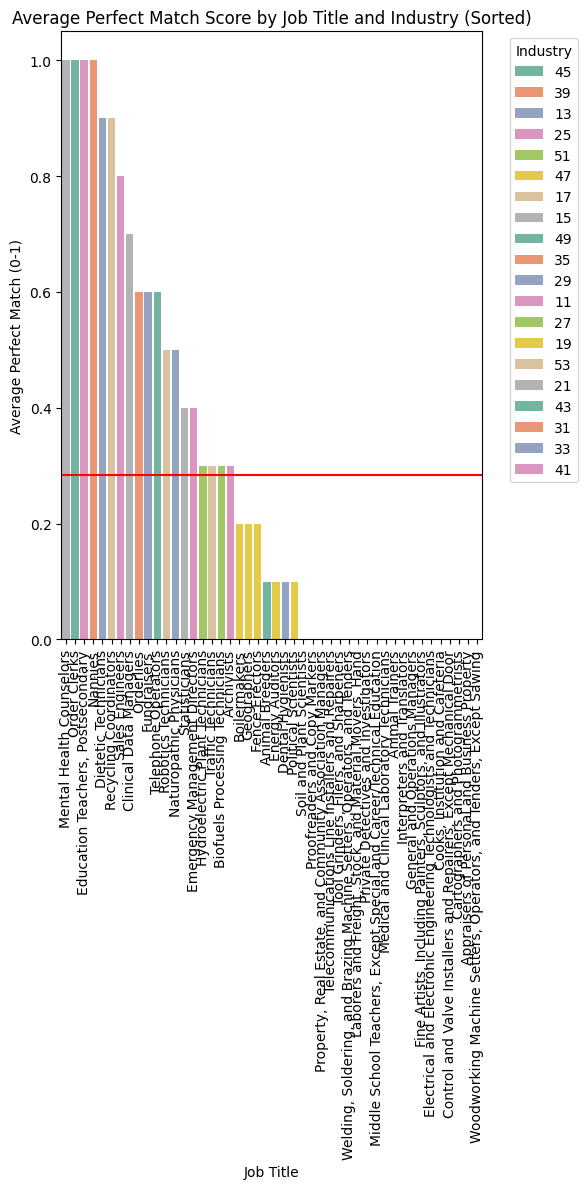

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame (e.g., no_prompt_df)
df["ind"] = df["ind"].astype(str)
df["zone"] = df["zone"].astype(str)

# Calculate mean perfect_match per title to determine sort order
order = df.groupby("title")["perfect_match"].mean().sort_values(ascending=False).index

# Create figure
plt.figure(figsize=(6, 12))

# Bar plot: mean perfect_match by title, colored by ind, sorted descending
sns.barplot(data=df, x="title", y="perfect_match", hue="ind", palette="Set2", order=order)
#add a mean score
plt.axhline(y= df["perfect_match"].sum() / len(df), color='r', linestyle='-')

# Customize
plt.xticks(rotation=90)
plt.title('Average Perfect Match Score by Job Title and Industry (Sorted)')
plt.xlabel('Job Title')
plt.ylabel('Average Perfect Match (0-1)')
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show plot
plt.show()

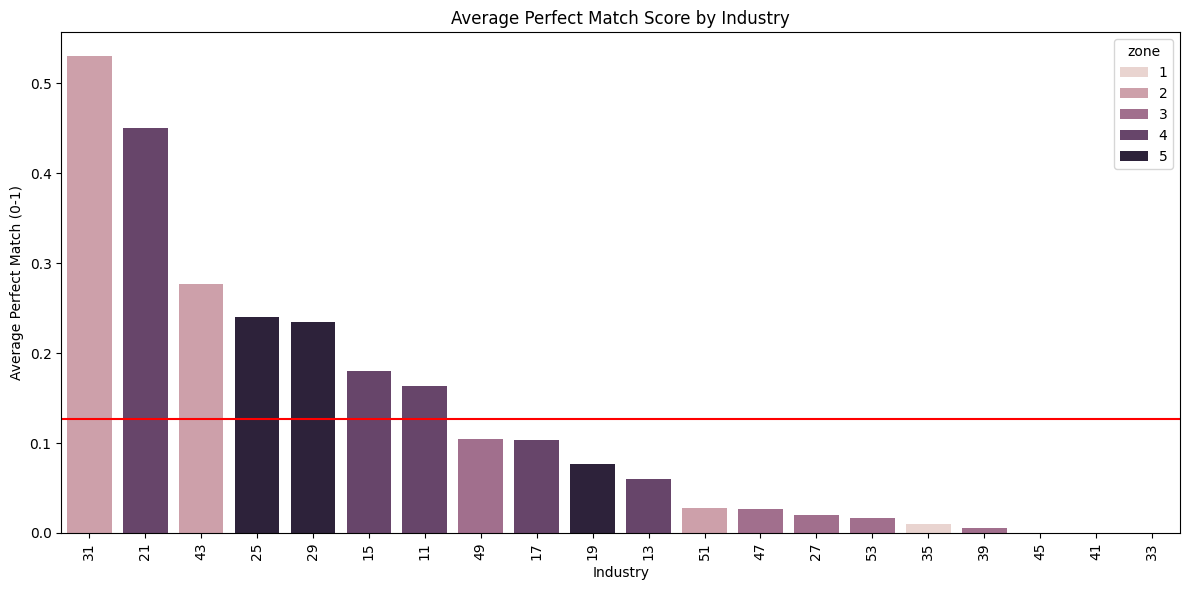

In [22]:
ind_plot = df[["ind", "perfect_match", "related", "zone"]].groupby("ind").agg({"perfect_match":"mean", "related":"mean", "zone":"first"}).reset_index()

# plot perfect match by industry
plt.figure(figsize=(12, 6))
# sns.barplot(data=ind_plot, x="ind", y="perfect_match", order=ind_plot.sort_values("perfect_match", ascending=False)["ind"], hue="zone")
sns.barplot(data=ind_plot, x="ind", y="related", order=ind_plot.sort_values("related", ascending=False)["ind"], hue="zone")
# add a mean score line
plt.axhline(y= ind_plot["related"].mean(), color='r', linestyle='-')
plt.xticks(rotation=90)
plt.title('Average Perfect Match Score by Industry')
plt.xlabel('Industry')
plt.ylabel('Average Perfect Match (0-1)')
plt.tight_layout()
plt.show()


In [23]:
zone_plot = df[["zone", "perfect_match", "related"]].groupby("zone").agg({"perfect_match":"mean", "related":"mean"}).reset_index()
#sort by perfect match
# zone_plot = zone_plot.sort_values("perfect_match", ascending=False)
zone_plot = zone_plot.sort_values("related", ascending=False)

zone_plot

,zone,perfect_match,related
4,5,0.357143,0.198571
3,4,0.220000,0.151333
2,3,0.100000,0.089000
1,2,0.181818,0.086364
0,1,0.000000,0.006667


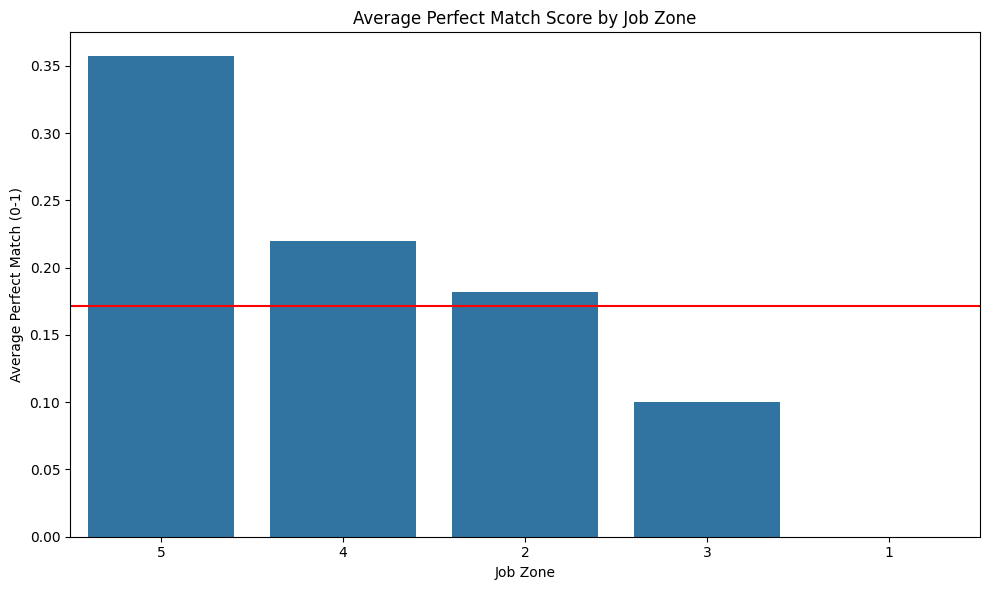

In [24]:
# plot perfect match by zone
plt.figure(figsize=(10, 6))
sns.barplot(data=zone_plot, x="zone", y="perfect_match", order=zone_plot.sort_values("perfect_match", ascending=False)["zone"])
#add a mean score line
plt.axhline(y= zone_plot["perfect_match"].mean(), color='r', linestyle='-')
plt.title('Average Perfect Match Score by Job Zone')
plt.xlabel('Job Zone')
plt.ylabel('Average Perfect Match (0-1)')
plt.tight_layout()
plt.show()


In [25]:
# plot the match score by job zone
sns.boxplot(x='zone', y='perfect_match', data=x)
plt.title('Perfect Match Score by Job Zone')
plt.show()

TypeError: Data source must be a DataFrame or Mapping, not <class 'int'>.

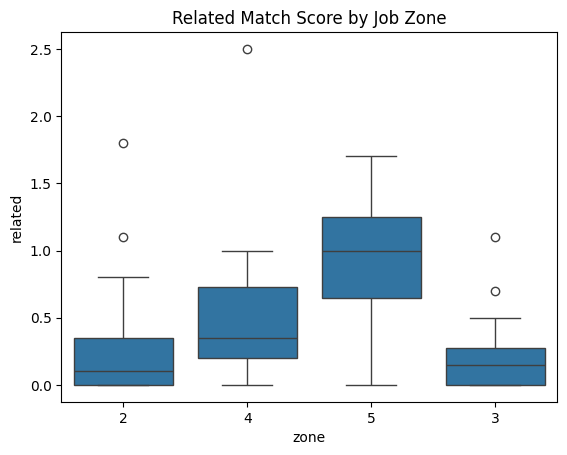

In [153]:
#plot the related score by job zone
sns.boxplot(x='zone', y='related', data=x)
plt.title('Related Match Score by Job Zone')
plt.show()

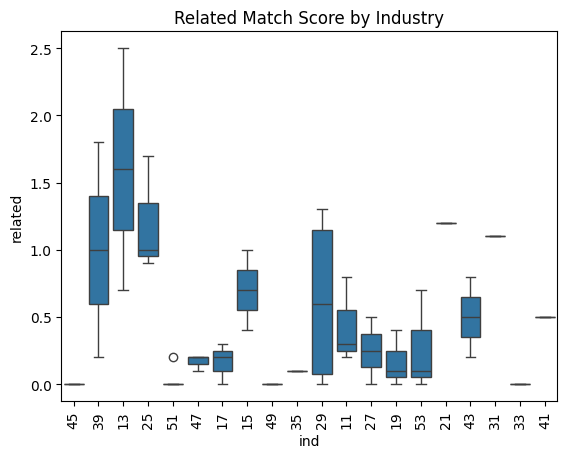

In [154]:
#plot the related score by industry
sns.boxplot(x='ind', y='related', data=x)
plt.title('Related Match Score by Industry')
plt.xticks(rotation=90)
plt.show()


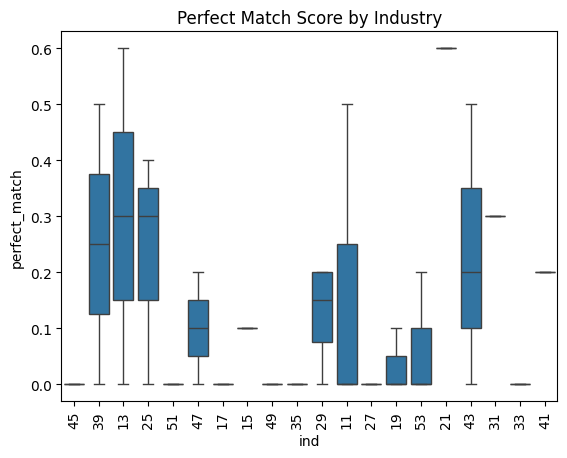

In [155]:
#plot the perfect match by industry
sns.boxplot(x='ind', y='perfect_match', data=x)
plt.title('Perfect Match Score by Industry')
plt.xticks(rotation=90)
plt.show()


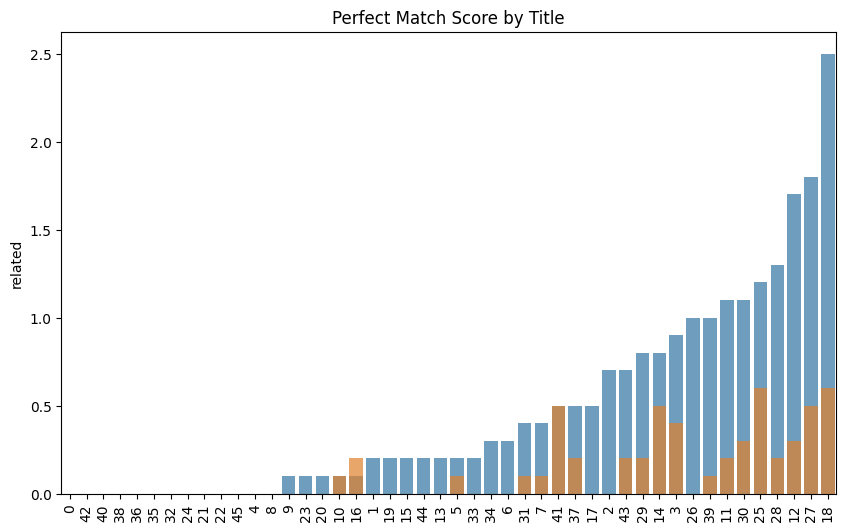

In [156]:
# plot for perfect match by title
plt.figure(figsize=(10, 6))
#x axis is the title, y axis is the score
# make the bars transparent
sns.barplot(x["related"], order=x["related"].sort_values().index, alpha=0.7)
sns.barplot(x["perfect_match"], alpha=0.7)
#plot the related score

#rotate the title
plt.xticks(rotation=90)
#add title
plt.title('Perfect Match Score by Title')
plt.show()


In [ ]:
industry	iteration	score
a	1	x
b	1	x
c	1	x
a	2	x
b	2	x
c	2	x


,ind,perfect_match,related
0,11,0.166667,0.433333
1,13,0.300000,1.600000
2,15,0.100000,0.700000
3,17,0.000000,0.166667
4,19,0.033333,0.166667
5,21,0.600000,1.200000
6,25,0.233333,1.200000
7,27,0.000000,0.250000
8,29,0.125000,0.625000
9,31,0.300000,1.100000


In [ ]:
import numpy as np
from scipy import stats
from statsmodels.stats.power import TTestPower
x = 2
no_prompt_model = model_name[x]
prompt_1_model = model_name[x+1]

# no_prompt = related_array_list[x] 
# prompt_1 = related_array_list[x+1]

no_prompt = perfect_array_list[x]
prompt_1 = perfect_array_list[x+1]

# 2 Sample t-test (H1: Prompt1 > No Prompt)
t_stat, p_value_two_tailed = stats.ttest_ind(prompt_1, no_prompt)
p_value_one_tailed = p_value_two_tailed / 2 if t_stat > 0 else 1 - (p_value_two_tailed / 2)
print(f"Two-Sample t-test ({prompt_1_model} > {no_prompt_model}):")
print(f"t-statistic: {t_stat:.4f}, p-value (one-tailed): {p_value_one_tailed:.8f}")

# Interpretation
alpha = 0.05
if p_value_one_tailed < alpha and np.mean(prompt_1) > np.mean(no_prompt):
    print("Result: Reject H₀. Prompt1 significantly improves scores.")
else:
    print("Result: Fail to reject H₀. Prompt1 does not significantly improve scores.")

# Cohen's d (for paired data)
diffs = prompt_1 - no_prompt
cohen_d = np.mean(diffs) / np.std(diffs, ddof=1)
print(f"Cohen's d: {cohen_d:.4f}")

# Power analysis (paired t-test)
power_analysis = TTestPower()
sample_size = power_analysis.solve_power(effect_size=abs(cohen_d), nobs=None, alpha=alpha, power=0.8, alternative='larger')
print(f"Required sample size (runs): {int(np.ceil(sample_size))} (for power = 0.8, alpha = 0.05)")

Two-Sample t-test (llama_prompt_1 > llama_no_prompt):
t-statistic: 3.1305, p-value (one-tailed): 0.00289013
Result: Reject H₀. Prompt1 significantly improves scores.
Cohen's d: 0.8830
Required sample size (runs): 10 (for power = 0.8, alpha = 0.05)
